# Week 9: 資料兼課題

## 0. この資料の目標

今週の授業では，ソローモデルのシミュレーションを完成させます。

下記の課題I, II, III, IV に答えてください。第9週のリアルタイムセッションに参加している方は，授業内で取り組みます。

- コードの一部が `_______` となっているものがあります。これは「穴埋め」問題です。適切なコードに書き換えて実行してください。
- `assert` から始まる文は書いたコードが期待通り動いているかをチェックするためのテスト用コードです。消さないでください。期待通り動いている場合は何も起こりません。
- コードの中には前後に依存関係のあるものがあります。すべてのコードを上から順に実行してください。

### 0.1. 提出方法

MS Teams の対応する課題に ipynb ファイルを添付して提出する。  

- 提出前に Kernel > Restart Kernel and Run All Cells... を実行して，エラーが生じないことを確認してください。

### 0.2. 締切

2020/7/9

### 0.3. 準備

まず，必要なライブラリをインポートしてください。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

図の画質を上げるために次のコードを実行しておきます。Word ファイルにドラッグ&ドロップで貼り付ける場合などに便利です。  
※ dpi = dot per inch, 1インチにどれだけの点を打つか。

In [2]:
import matplotlib
matplotlib.rcParams['figure.dpi'] = 150

## I. ソロー・モデルの時間発展ルール

ソローモデルのセットアップをします。

$$
\begin{aligned}
    K_t &= sF(K_{t-1}, L_{t-1}, A_{t-1}) + (1 - \delta) K_{t-1}\\
    L_t &= (1 + n) L_{t-1}\\
    A_t &= (1 + g) A_{t-1}
\end{aligned}
$$

ここで各変数，パラメータの意味は以下の通り。

- $K$: 資本ストック, 上記の「資本蓄積方程式」に従って変化
- $s$: 貯蓄率
- $\delta$: 資本減耗率
- $L$: 労働, 成長率 $n$ で変化
- $A$: 技術ストック, 成長率 $g$ で変化



#### (1) 生産関数

生産関数はコブダグラス型，技術進歩は労働節約的とします。

$$F_\alpha (K, L, A) = K^\alpha (A L)^{1-\alpha}$$


$\alpha \in [0, 1]$ を入力すると，コブ=ダグラス型生産関数 $F_\alpha$ を出力する Python の関数 `cd_factory` を定義しなさい。

[解答]

In [3]:
## EXERCISE ## 

def cd_factory(a):
    def Fa(K, L, A):
        return K**a * (A * L)**(1-a)
    return Fa

In [5]:
## TEST ##
assert np.allclose(cd_factory(1)(1, 1, 1), 1)
assert np.allclose(cd_factory(0)(1, 1, 2), 2)
assert np.allclose(cd_factory(0.5)(4, 2, 2), 4)

#### (2) 時間発展ルール

上記のソロー・モデルの式は $(t-1)$期の情報から $t$期の情報を作るルールになっています。

$$
\begin{bmatrix}
  K_{t-1}\\
  L_{t-1}\\
  A_{t-1}
\end{bmatrix}
\mapsto
\begin{bmatrix}
  K_{t}\\
  L_{t}\\
  A_{t}
\end{bmatrix}
=
\begin{bmatrix}
    sF(K_{t-1}, L_{t-1}, A_{t-1}) + (1 - \delta) K_{t-1}\\
    (1 + n) L_{t-1}\\
    (1 + g) A_{t-1}
\end{bmatrix}
$$

ここで，

$$
G(K_{t-1}, L_{t-1}, A_{t-1})
=
\begin{bmatrix}
    sF(K_{t-1}, L_{t-1}, A_{t-1}) + (1 - \delta) K_{t-1}\\
    (1 + n) L_{t-1}\\
    (1 + g) A_{t-1}
\end{bmatrix}
$$

とします。ここで，$G$ は

- $s$
- $\delta$
- $g$
- $n$ 
- $F$

に依存して決まります。数値パラメータ $s, \delta, g, n$ と 関数 $F$ を入力として，$G$ を出力にするPython関数 `solow`を定義してみましょう。出力される関数 `G` は $(t-1)$-期の情報を NumPy 配列として受け取って，同じサイズの NumPy 配列を返すものとします。

In [6]:
x = np.array([1, 2, 3])
a, b, c = x

In [9]:
c

3

In [11]:
## EXERCISE ##

def solow(s, delta, g, n, F):
    
    def G(x):
        K0, L0, A0 = x
        K1 = s * F(K0, L0, A0) + (1 - delta) * K0
        L1 = (1 + n) * L0
        A1 = (1 + g) * A0
        
        return np.array([K1, L1, A1])
    
    return G

In [17]:
G_solow = solow(s=0.3, delta=0.08, g=0.03, n=0.01, F=cd_factory(0.3))
x = np.array([2, 2, 2])
G_solow(x)

array([2.74942994, 2.02      , 2.06      ])

In [18]:
## TEST ##
assert np.allclose(G_solow(np.array([1, 1, 1])), np.array([1.05, 1.01, 1.03]))

AssertionError: 

## II. シミュレーション

過去から未来を決める「関数」と初期値 $(K_0, L_0, A_0)$ が定まっているときにはシミュレーションは簡単です。初期値から初めて順々に計算していくだけです。基本的な方法は AR過程のときと同じなので，今回はもう少しスマートな方法を紹介します。

シミュレーションとは，

- 時間発展ルール $G$ と
- 初期値 $(K_0, L_0, A_0)$ 

から，時系列を計算する作業のことです。

$$
\left(G, (K_0, L_0, A_0) \right)
\mapsto
\begin{bmatrix}
    K_0 & L_0 & A_0 \\
    K_1 & L_1 & A_1 \\
    K_2 & L_2 & A_2 \\
    K_3 & L_3 & A_3 \\
    \vdots & \vdots & \vdots
\end{bmatrix}
$$

シミュレーションの終了条件としては，次の2通りの考え方があります。

1. ある一定の期間で止める，または，
1. 収束条件が成り立ったときに止める。ただし，収束条件が成り立たないときは，ある一定の期間で強制的に止める

ここではより簡単な 1 の考え方を採用します。シミュレーションの期間を `T` とします。したがって，私たちは


- 時間発展ルール $G$ と
- 初期値 $(K_0, L_0, A_0)$ 
- シミュレーションの期間 $T$ 

から，時系列を計算する作業を関数化すればよいことになります。

$$
\left(G, (K_0, L_0, A_0), T \right)
\mapsto
\begin{bmatrix}
    K_0 & L_0 & A_0 \\
    K_1 & L_1 & A_1 \\
    K_2 & L_2 & A_2 \\
    K_3 & L_3 & A_3 \\
    \vdots & \vdots & \vdots\\
    K_{T-1} & L_{T-1} & A_{T-1}
\end{bmatrix}
$$

初期値を `y0` という NumPy 配列に格納すると，結果の配列は初期値よりも次元が 1 つだけ大きくなることに注意します。

例えば，

- 初期値の shape, `y0.shape` が `(a,)` のとき，シミュレーション結果の shape は `(T, a)`
- 初期値の shape が `(a, b)` のとき，シミュレーション結果の shape は `(T, a, b)`

初期値の shape に関わらず次の `*` 演算子を使ったコードで結果の配列のサイズを指定できます。


**[問題]** 下の `shp` に代入するタプルを書き換えて実験してみよう。

In [19]:
shp = (3,)
(100, *shp)

(100, 3)

In [20]:
shp = (3, 4)
(100, *shp)

(100, 3, 4)

準備が整ったので，シミュレーションの関数を定義します。
`np.asarray()` は初期値をリストとしても渡せるようにするためにつけてます。

In [21]:
## EXERCISE ##

def simulate(G, y0, T):
    y0 = np.asarray(y0)
    y = np.empty((T, *y0.shape))
    y[0] = y0
    for t in range(1, T):
        y[t] = G(y[t-1])
    return y

In [22]:
## EXERCISE ## 

# パラメータ
s = 0.1
delta = 0.05
g = 0.03
n = 0.01

# 生産関数
F = cd_factory(0.3)

# 時間発展ルール
G_solow = solow(s=s, delta=delta, g=g, n=n, F=F)

# 初期値
y0 = np.array([3, 1, 1])

# シミュレーションのコード
simulate(G_solow, y0, 10)

array([[3.        , 1.        , 1.        ],
       [2.98903892, 1.01      , 1.03      ],
       [2.98236799, 1.0201    , 1.0609    ],
       [2.97993618, 1.030301  , 1.092727  ],
       [2.9817025 , 1.04060401, 1.12550881],
       [2.98763582, 1.05101005, 1.15927407],
       [2.99771463, 1.06152015, 1.1940523 ],
       [3.01192686, 1.07213535, 1.22987387],
       [3.03026973, 1.08285671, 1.26677008],
       [3.05274955, 1.09368527, 1.30477318]])

## III. ソロー・モデルの長期的な挙動

可視化には Pandas を使うと便利。

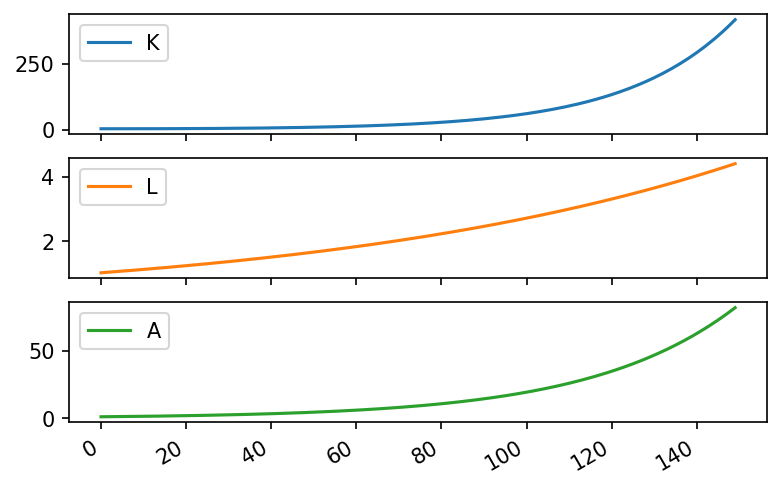

In [23]:
## EXERCISE ## 

y = simulate(G_solow, y0, 150)
result = pd.DataFrame(y, columns=['K', 'L', 'A'])
result.plot(subplots=True);

ソロー・モデルでは効率労働あたりの資本

$$
k = \frac{K}{AL}
$$

がある水準に収束する。これを確認しよう。

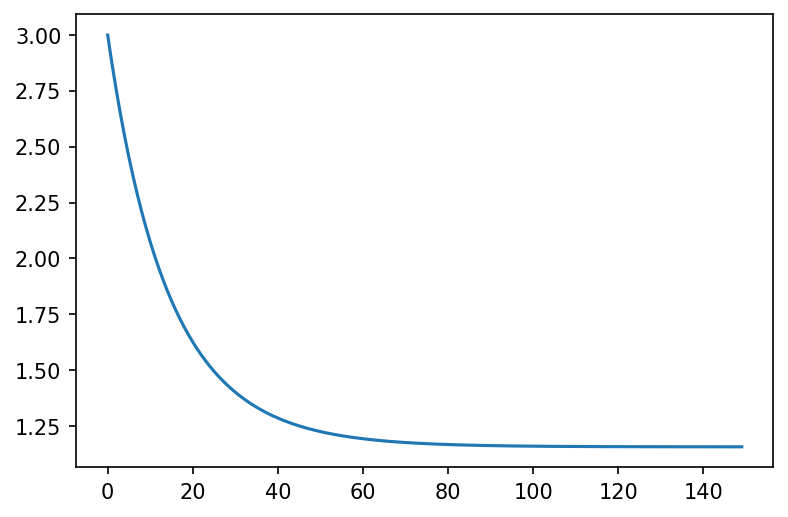

In [24]:
## EXERCISE ##

k = result.K / result.A / result.L
k.plot();

#### 命題

$k$ が十分に収束した後の長期においては，

- 総生産 $Y = F(K, L, A)$ は $g + n + gn$ の率で成長する。
- 一人あたり総生産 $Y / L$ は $g$ の率で成長する。

これを確認しよう。

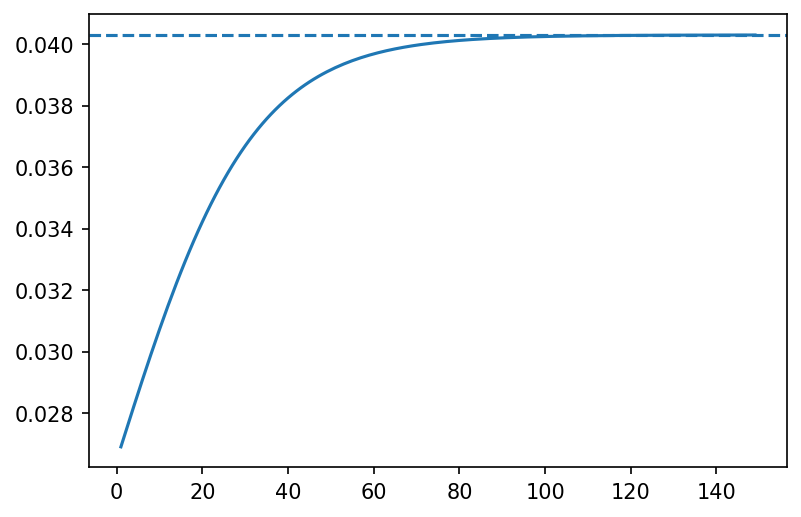

In [27]:
## EXERCISE ## 
Y = F(result.K, result.L, result.A)
Y.pct_change().plot()
plt.axhline(g + n + g * n, linestyle='--');

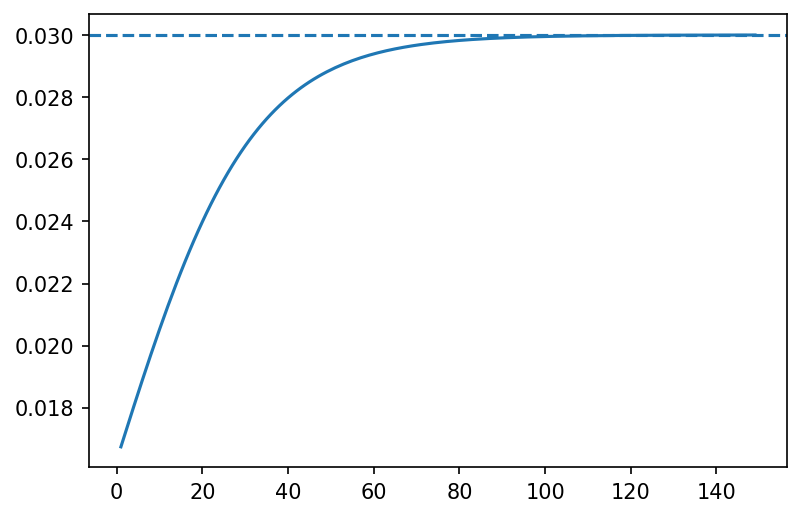

In [28]:
## EXERCISE ## 
y = Y / result.L
y.pct_change().plot()
plt.axhline(g, linestyle='--');

## IV. 課題

パラメータを変えてもう一度シミュレーションをしてみよう。定義済みの関数を書き換える必要はない。

In [ ]:
## EXERCISE ##

# パラメータ
s = _____
delta = _____
g = _____
n = _____
alpha = _____
T = _____

In [ ]:
# 生産関数
F = cd_factory(alpha)

# 時間発展ルール
G_solow = solow(s=s, delta=delta, g=g, n=n, F=F)

# 初期値
y0 = np.array([3, 1, 1])

# シミュレーションのコード
y = simulate(G_solow, y0, T)

In [ ]:
result = pd.DataFrame(y, columns=['K', 'L', 'A'])
result.plot(subplots=True);

In [ ]:
Y = F(result.K, result.L, result.A)
Y.pct_change().plot()
plt.axhline(g + n + g*n, linestyle='--');

In [ ]:
y = Y / result.L
y.pct_change().plot()
plt.axhline(g, linestyle='--');

## 終わりに

- 上で定義した関数 `simulate` はかなり汎用的に使えます。AR(1) とか AR(2) モデルのシミュレーションに使うにはどのようにすればよいかを考えてみましょう。
- ソローモデルの重要な分析として，比較動学というものがあります。経済が，あるパラメータの組み合わせに対する定常状態（$k$ が収束した状態）にあると考えて，1つのパラメータが変化した後にどのような挙動を示すかを分析するものです。2つのシミュレーションをつなぎ合わせればできるので，試してみてください。

いずれのケースも Ch06.pdf に解説してありますので，ご確認ください。

**穴埋め済みの ipynb ファイルを提出してください。締切: 7/10**